In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import dataframe_image as dfi
import seaborn as sns



In [3]:
bars_color = "gray"

In [7]:
def plot_figure(fig_width=2, fig_height=2):
    #define apeearance of figures

    COLOR = 'black'


    # Edit the font, font size, color and axes width

    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.linewidth'] = 0.5

    tick_size=3
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])


    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')

    return fig, ax




def get_readmittion_rates(data, column_name, min_size=0, min_size_wrong=0):
    df = data.copy()
    df.dropna(subset = [column_name], inplace=True)
    groups = df[column_name].unique()

    readmittion_rates = []
    groups_to_consider = []
    sample_size = []

    for group in groups:
        group_df = df[df[column_name]==group]
        if len(group_df) >= min_size:
            num_wrong_discharge = group_df.readmitted.sum()
            if num_wrong_discharge>=min_size_wrong:
                groups_to_consider.append(group)
                readmittion_rates.append(num_wrong_discharge/len(group_df))
                sample_size.append(len(group_df))


    
    return groups_to_consider, readmittion_rates, sample_size


def check_for_discrimination(data, column_name, subgroup = False, min_size=0, min_size_wrong=0):

    df = data.copy()
    df.readmitted = df.readmitted.replace(["Yes", "No"], [True, False])
    
    if subgroup:
        column_values = df[subgroup].unique()
        for column_value in column_values:
            df_subgroup = df[df[subgroup]==column_value]
            df_subgroup.dropna(subset = [subgroup], inplace=True)
            return get_readmittion_rates(df_subgroup, column_name, min_size, min_size_wrong)

    else: 
        return get_readmittion_rates(df, column_name, min_size, min_size_wrong)


def plot_wrongful_discharges(data, column_name, x_label = "", sub_group = False, min_size = 0, min_size_wrong = 0, fig_width=2, return_figure=True, rotation=90, plot_average = True, plot_14=True):
    groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, sub_group, min_size, min_size_wrong)
    
    data_to_plot = pd.DataFrame(list(zip([r*100 for r in readmittion_rates], sample_size)), index = groups)
    if len(data_to_plot)>0:
        fig, ax = plot_figure(fig_width)
        data_to_plot = data_to_plot.sort_index()
        #Standard Error of the Proportion Formula:
        sep = np.sqrt(data_to_plot[0].values*(100- data_to_plot[0].values)/(data_to_plot[1]))
        if return_figure: 

            if plot_average:
                plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
            if plot_14:
                plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
            ax.bar(data_to_plot[0].index, data_to_plot[0].values, yerr = sep, color = bars_color)
            plt.xticks(rotation=rotation)


            ax.set_ylabel("% of wrongful discharges")
            ax.set_xlabel(x_label)
            return fig, ax
 
        
        else: 
            return data_to_plot[0].index, data_to_plot[0].values, sep

    

def get_subgroup_percentages(data, column, subgroups):
    percentages = []
    for subgroup in subgroups:
        percentages.append((data[column]==subgroup).sum()/len(data.dropna(subset=[column])))
    return percentages

    

def filter_common_categories(data, column_name, threshold):
    common_categories = list(data[column_name].value_counts()[data[column_name].value_counts()>threshold].index.values)
    common_categories.append(np.nan)
    data[column_name+"_simplified"] = np.where(data[column_name].isin(common_categories), data[column_name], 'Other')
    data[column_name+"_simplified"] = data[column_name+"_simplified"].replace("nan", np.nan)
    return common_categories




def get_difference_between_groups(groups, readmittion_rates):
    print(f"max difference: {(max(readmittion_rates) - min(readmittion_rates))*100}")
    print(f"Highest rate: {groups[np.where(readmittion_rates==max(readmittion_rates))[0][0]]}")
    print(f"Lowest rate: {groups[np.where(readmittion_rates==min(readmittion_rates))[0][0]]}")

In [4]:
dataset_name = "cleaned_data"
#dataset_name = "cleaned_first_round"

data = pd.read_csv(f"data/{dataset_name}.csv")

data

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted_proba,true_class,readmitted
0,95646.0,2590308.0,NaN,Male,[70-80),NaN,2.0,1.0,NaN,1.0,...,False,None,None,No,No,No,Yes,0.401941,0.0,No
1,87927.0,190052460.0,Caucasian,Male,[60-70),NaN,2.0,1.0,1.0,1.0,...,False,None,None,No,No,Ch,Yes,0.395329,0.0,No
2,99160.0,6887610.0,Hispanic,Female,[40-50),NaN,1.0,NaN,7.0,1.0,...,False,None,None,No,No,Ch,Yes,0.423172,0.0,No
3,90155.0,61379460.0,Other,Female,[60-70),NaN,2.0,1.0,7.0,1.0,...,False,None,>8,No,Yes,Ch,Yes,0.468113,0.0,No
4,90613.0,186370740.0,Caucasian,Male,[50-60),NaN,1.0,1.0,1.0,1.0,...,True,None,>8,No,Yes,Ch,Yes,0.443700,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9678,86996.0,169291854.0,Caucasian,Female,[70-80),NaN,1.0,1.0,7.0,6.0,...,True,None,None,No,No,No,No,0.452251,0.0,No
9679,90525.0,117898740.0,Other,Male,NaN,NaN,2.0,1.0,1.0,2.0,...,True,None,None,No,No,No,No,0.404220,0.0,No
9680,99372.0,15918588.0,African American,Male,[60-70),[50-75),1.0,1.0,7.0,5.0,...,False,None,>8,No,Yes,No,Yes,0.524683,0.0,No
9681,87175.0,12951306.0,Caucasian,Male,[60-70),NaN,3.0,1.0,1.0,1.0,...,False,None,None,No,No,No,Yes,0.403837,0.0,No


In [ ]:
#is patient insured
payer_codes = list(data.payer_code.dropna().unique())
payer_codes.remove("SP")

data["isInsured"] = data.payer_code.replace(list(payer_codes), "Yes")
data["isInsured"] = data.isInsured.replace("SP", "No")

In [7]:
threshold=len(data.dropna(subset=["medical_specialty"]))*0.01
filter_common_categories(data, "medical_specialty", threshold)


['InternalMedicine',
 'Emergency/Trauma',
 'Family/GeneralPractice',
 'Cardiology',
 'Surgery-General',
 'Orthopedics',
 'Orthopedics-Reconstructive',
 'Radiologist',
 'Nephrology',
 'Psychiatry',
 'Pulmonology',
 'Urology',
 'Surgery-Cardiovascular/Thoracic',
 'ObstetricsandGynecology',
 'Gastroenterology',
 'Surgery-Vascular',
 nan]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


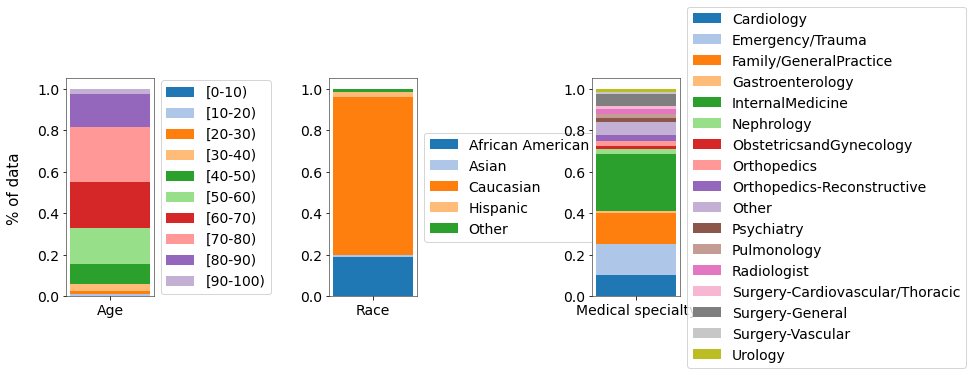

In [8]:
colors = plt.get_cmap("tab20").colors
diagnosis_legend = ["external", "pregnancy...", "congential", "blood", "circulatory", "digestive", "genitourinary", "muscule", "nervous", "respiratory", "skin", "endocrine...", "infectious", "injury", "mental", "neoplasms", "symptoms..."]
#nonnumerical_columns = ["gender", "age", "isInsured", "race", "medical_specialty"]
nonnumerical_columns = ["age", "race", "medical_specialty_simplified"]
column_names = ["Age", "Race", "Medical specialty"]

n_cols = 3
bar_width=0.8
if len(nonnumerical_columns)/n_cols == len(nonnumerical_columns)//n_cols: n_rows = len(nonnumerical_columns)//n_cols
else : n_rows = len(nonnumerical_columns)//n_cols+1
fig, ax = plot_figure(fig_width=n_cols*2+5, fig_height=2*n_rows+2)

new_axs = []
for plot_num, column in enumerate(nonnumerical_columns):
    ax = plt.subplot(n_rows, n_cols, plot_num+1)
  
    subgroups = data[column].dropna().unique()
    subgroups = sorted(subgroups)


    percentages = get_subgroup_percentages(data, column, subgroups)

    cumulative_perc=0
    label_i=0
    name = column_names[plot_num]
    for subgroup, percentage, color in zip(subgroups, percentages, colors):
        ax.bar(name, percentage, bar_width,  bottom=cumulative_perc, label=subgroup, color=color)
        cumulative_perc+=percentage
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)


    
    plt.xticks(fontsize= 14, rotation=0) 
    plt.yticks(fontsize= 14)


plt.subplots_adjust(hspace=0.5, wspace = 2)
fig.text(0.06, 0.5, '% of data', ha='center', va='center', rotation='vertical')
fig.savefig('variables_distribution.png', dpi=300, transparent=True, bbox_inches='tight')



In [9]:
data.isInsured.value_counts()/len(data.dropna(subset=["isInsured"]))

Yes    0.916082
No     0.083918
Name: isInsured, dtype: float64

In [10]:
data.gender.value_counts()/len(data.dropna(subset=["gender"]))

Female    0.541107
Male      0.458893
Name: gender, dtype: float64

In [11]:
df = pd.DataFrame(list(zip((data.isnull().sum()/len(data)*100).values, data.nunique().values, data.dtypes.values)),  
    columns=["% of missing values", "Number of unique values", "Data type"], index=data.columns)

dfi.export(df, f"{dataset_name}_overview.png")

[0303/213546.394381:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0303/213547.055565:INFO:headless_shell.cc(648)] Written to file /tmp/tmpxeb2scj3/temp.png.
[0303/213547.799494:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0303/213548.728790:INFO:headless_shell.cc(648)] Written to file /tmp/tmpd8uhwklc/temp.png.


In [135]:
all_features = ['race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed']



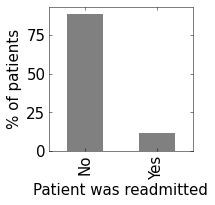

In [136]:
fig, ax = plot_figure()
(data.readmitted.value_counts()/len(data)*100).plot(kind="bar", color = bars_color)
ax.set_ylabel("% of patients")
ax.set_xlabel("Patient was readmitted")
title="Target_distribution"
fig.savefig(f'{title}_{dataset_name}.png', dpi=300, transparent=True, bbox_inches='tight')

In [137]:
data.readmitted.value_counts()

No     70202
Yes     8992
Name: readmitted, dtype: int64

In [138]:
(data.readmitted.value_counts()/len(data))

No     0.886456
Yes    0.113544
Name: readmitted, dtype: float64

In [139]:
data.dropna(subset=["readmitted"], inplace=True)

In [140]:
average_wrong_discharge_rate = (data.readmitted.value_counts()/len(data)).Yes
average_wrong_discharge_rate

0.11354395535015278

In [141]:
data["readmitted_bool"] = data.readmitted.replace(["Yes", "No"], [True, False])

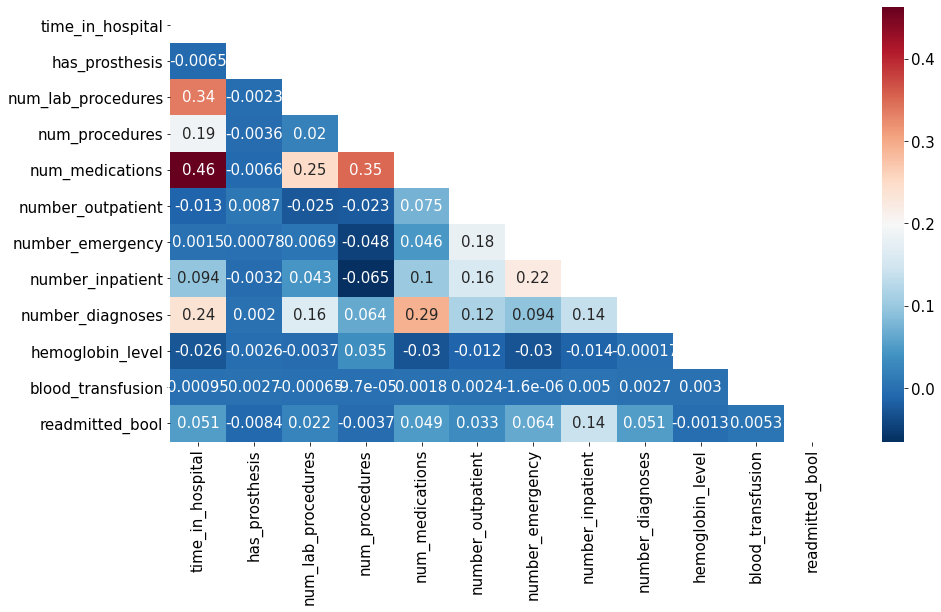

In [142]:
try: cor_mat = data.drop(["admission_id", "patient_id", "admission_type_code", "discharge_disposition_code", "admission_source_code", "readmitted_proba", "true_class"], axis=1).corr(method="spearman")
except: cor_mat = data.drop(["admission_id", "patient_id", "admission_type_code", "discharge_disposition_code", "admission_source_code"], axis=1).corr(method="spearman")
lower_triangle_mask = np.triu(np.ones(cor_mat.shape)).astype(np.bool)
cor_mat_lower = cor_mat.mask(lower_triangle_mask)

fig = plt.figure(figsize = (15,8)) # <-- just sets the figure size 
sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); # <-- use a "red into blue, reversed" colormap

fig.savefig(f'corr_matrix_{dataset_name}_.png', dpi=300, transparent=True, bbox_inches='tight')

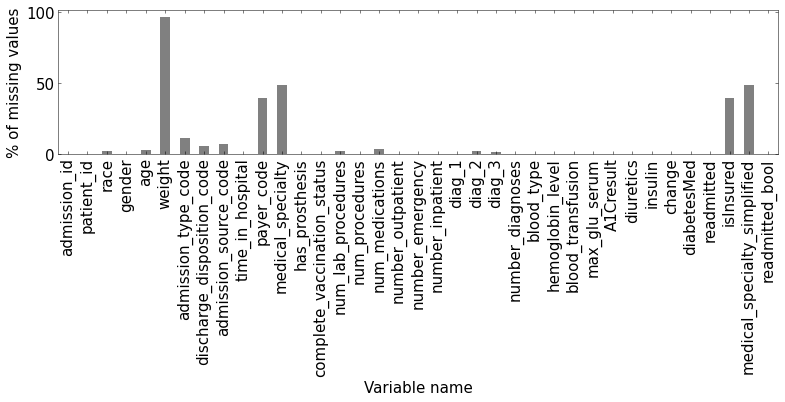

In [143]:
fig, ax = plot_figure(fig_width=10)
#data.gender.value_counts().plot(kind="bar", color = bars_color)
(data.isnull().sum()/len(data)*100).plot.bar(color = bars_color)
ax.set_ylabel("% of missing values")
ax.set_xlabel("Variable name")
title="Missing_values"
fig.savefig(f'{title}_{dataset_name}_.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
data_old = pd.read_csv(f"data/cleaned_data.csv")
data_new = pd.read_csv(f"data/cleaned_first_round.csv")
payer_codes_old = list(data_old.payer_code.dropna().unique())
payer_codes_old.remove("SP")
data_old["isInsured"] = data_old.payer_code.replace(list(payer_codes_old), "Yes")
data_old["isInsured"] = data_old.isInsured.replace("SP", "No")

payer_codes_new = list(data_new.payer_code.dropna().unique())
payer_codes_new.remove("SP")
data_new["isInsured"] = data_new.payer_code.replace(list(payer_codes_new), "Yes")
data_new["isInsured"] = data_new.isInsured.replace("SP", "No")



In [ ]:
#column_name = "medical_specialty"
column_name = "race"
#column_name = "gender"
#column_name = "age"
#column_name = "isInsured"


subgroups_old, values_old, sep_old  = plot_wrongful_discharges(data_old, column_name, x_label="Race", min_size=0, min_size_wrong=0, fig_width=3, plot_average=False, plot_14=False, return_figure=False)
subgroups_new, values_new, sep_new = plot_wrongful_discharges(data_new, column_name, x_label="Race", min_size=0, min_size_wrong=0, fig_width=3, plot_average=False, plot_14=False, return_figure = False)

subgroups_old_in_new = [s for s in subgroups_old if s in subgroups_new]
values_old_in_new  = [values_old[i] for i,s in enumerate(subgroups_old) if s in subgroups_new]
sep_old_in_new  = [sep_old[i] for i,s in enumerate(subgroups_old) if s in subgroups_new]

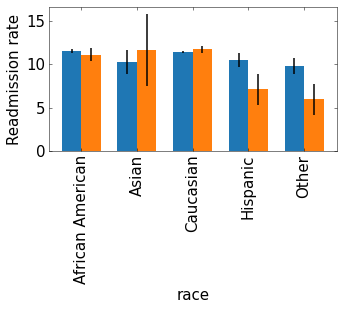

In [144]:
fig, ax = plot_figure(4,2)
x = np.arange(len(subgroups_new))
width = 0.35  # the width of the bars

ax.bar(x-width/2, values_old_in_new, yerr = sep_old_in_new, width=width, label="old dataset")
ax.bar(x+width/2, values_new, yerr = sep_new, width=width, label="new dataset")


ax.set_ylabel('Readmission rate')
ax.set_xticks(x)
ax.set_xlabel(column_name)
ax.set_xticklabels(list(subgroups_new.values))
plt.xticks(rotation = 90)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig(f'{column_name}_comparison_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')


In [151]:


threshold=len(data_old.dropna(subset=["medical_specialty"]))*0.01
filter_common_categories(data_old, "medical_specialty", threshold)


['InternalMedicine',
 'Emergency/Trauma',
 'Family/GeneralPractice',
 'Cardiology',
 'Surgery-General',
 'Nephrology',
 'Orthopedics',
 'Orthopedics-Reconstructive',
 'Radiologist',
 'Pulmonology',
 'Psychiatry',
 'Urology',
 'ObstetricsandGynecology',
 'Surgery-Cardiovascular/Thoracic',
 'Gastroenterology',
 'Surgery-Vascular',
 nan]

In [153]:

data_new["medical_specialty_simplified"] = np.where(data_new["medical_specialty"].isin(data_old.medical_specialty_simplified.unique()), data_new["medical_specialty"], "Other")
data_new["medical_specialty_simplified"] = data_new["medical_specialty_simplified"] .replace("nan", np.nan)


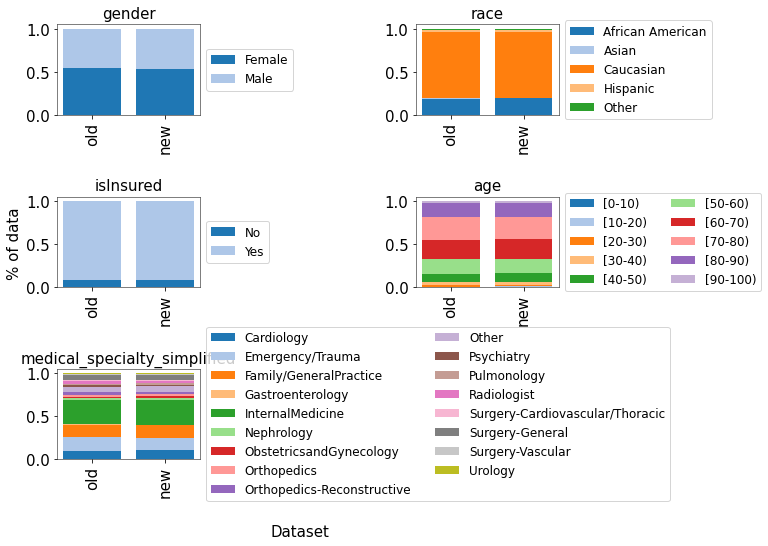

In [163]:
colors = plt.get_cmap("tab20").colors


nonnumerical_columns  = ["gender", "race", "isInsured", "age", "medical_specialty_simplified"]

n_cols = 2
bar_width=0.8
if len(nonnumerical_columns)/n_cols == len(nonnumerical_columns)//n_cols: n_rows = len(nonnumerical_columns)//n_cols
else : n_rows = len(nonnumerical_columns)//n_cols+1
fig, ax = plot_figure(fig_width=n_cols*2+5, fig_height=2*n_rows+2)

new_axs = []
for plot_num, column in enumerate(nonnumerical_columns):
    if plot_num<14:
        ax = plt.subplot(n_rows, n_cols, plot_num+1)
    else: ax = plt.subplot(n_rows, n_cols, plot_num+2)

  
    subgroups = pd.concat([data_new, data_old])[column].dropna().unique()
    subgroups = sorted(subgroups)


    old_percentages = get_subgroup_percentages(data_new, column, subgroups)
    new_percentages = get_subgroup_percentages(data_old, column, subgroups)

    cumulative_perc=0
    label_i=0
    for subgroup, percentage, color in zip(subgroups, old_percentages, colors):
        if plot_num==16: 
            ax.bar("old", percentage, bar_width,  bottom=cumulative_perc, label=diagnosis_legend[label_i], color=color)
            label_i+=1

        else: ax.bar("old", percentage, bar_width,  bottom=cumulative_perc, label=subgroup, color=color)
        cumulative_perc+=percentage
        

    if (plot_num==4 or plot_num==3): ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=2)

    else: ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)


    cumulative_perc=0
    for subgroup, percentage, color in zip(subgroups, new_percentages, colors):
        ax.bar("new", percentage, bar_width,  bottom=cumulative_perc, label=subgroup, color=color)
        cumulative_perc+=percentage
    
    plt.xticks(fontsize= 15, rotation=90) 
    plt.yticks(fontsize= 15)
    plt.title(column.replace("_code", ""), fontsize=15)


plt.subplots_adjust(hspace=0.9, wspace = 1.5)
fig.text(0.5, 0, 'Dataset', ha='center', va='center')
fig.text(0.06, 0.5, '% of data', ha='center', va='center', rotation='vertical')
fig.savefig(f'categorical_values_requirements_comparison.png', dpi=300, transparent=True, bbox_inches='tight')



In [ ]:
column_name = "race"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Race", min_size=0, min_size_wrong=0, fig_width=3)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')


In [147]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)

get_difference_between_groups(groups, readmittion_rates)

max difference: 1.7021016401514488
Highest rate: African American
Lowest rate: Other


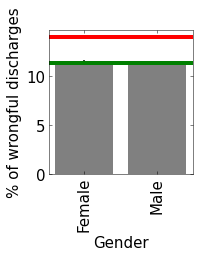

In [148]:
column_name = "gender"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Gender", min_size=0, min_size_wrong=0, fig_width=2)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [155]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups,  readmittion_rates)

max difference: 0.2083110778762956
Highest rate: Male
Lowest rate: Female


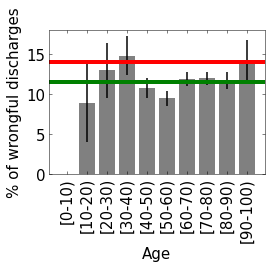

In [156]:
column_name = "age"

fig, ax = plot_wrongful_discharges(data, column_name, x_label="Age", min_size=0, min_size_wrong=0, fig_width=3)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [157]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups, readmittion_rates)

max difference: 14.746543778801843
Highest rate: [30-40)
Lowest rate: [0-10)


In [158]:
readmittion_rates

[0.1191358024691358,
 0.11843079200592153,
 0.10668789808917198,
 0.0941747572815534,
 0.1164021164021164,
 0.08823529411764706,
 0.14746543778801843,
 0.12903225806451613,
 0.13924050632911392,
 0.0]

In [159]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, min_size_wrong=3)
get_difference_between_groups(groups, readmittion_rates)

max difference: 5.923014367037137
Highest rate: [30-40)
Lowest rate: [10-20)


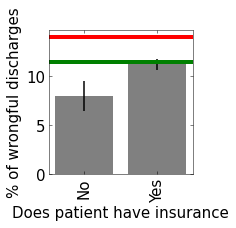

In [160]:
#is patient insured
payer_codes = list(data.payer_code.dropna().unique())
payer_codes.remove("SP")

data["isInsured"] = data.payer_code.replace(list(payer_codes), "Yes")
data["isInsured"] = data.isInsured.replace("SP", "No")
data["isInsured"].unique()

column_name = "isInsured"

fig, ax = plot_wrongful_discharges(data, column_name, x_label="Does patient have insurance", min_size=0, min_size_wrong=0, fig_width=2.)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [161]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups, readmittion_rates)

max difference: 3.2356834574583173
Highest rate: Yes
Lowest rate: No


In [162]:
readmittion_rates

[0.11197466896948763, 0.07961783439490445]

In [163]:
len(data.medical_specialty.unique())

48

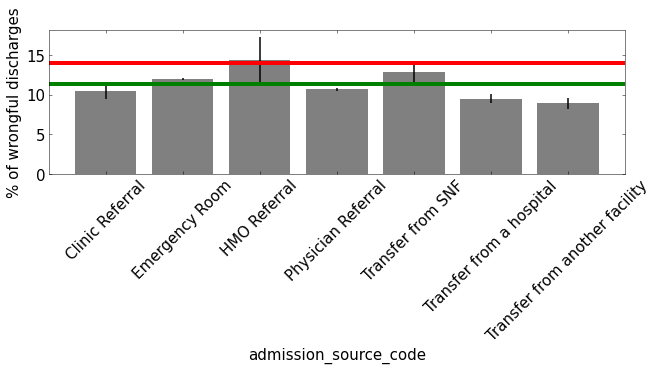

In [160]:
data["admission_source_code"] = data["admission_source_code"].astype(str)
data["admission_source_code"]  = data["admission_source_code"].replace("nan", np.nan)
data["admission_source_code"] = data["admission_source_code"].replace(["1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0"], ["Physician Referral", "Clinic Referral", "HMO Referral", "Transfer from a hospital", 
    "Transfer from SNF", "Transfer from another facility", "Emergency Room"])
column_name = "admission_source_code"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="admission_source_code", min_size=0, min_size_wrong=5, fig_width=8, rotation=45)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [161]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, min_size_wrong=5)

[(g, np.round(r*100, 2)) for g, r in zip(groups, readmittion_rates) if r>=0.14]

[('HMO Referral', 14.38)]

In [157]:
get_difference_between_groups(groups, readmittion_rates)

max difference: 5.450004971585476
Highest rate: HMO Referral
Lowest rate: Transfer from another facility


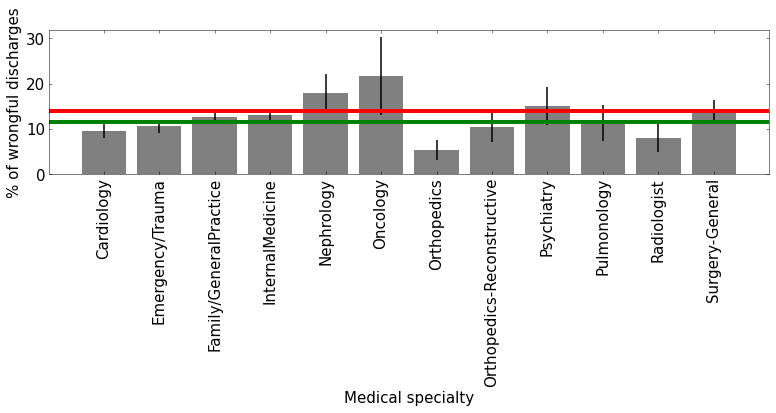

In [166]:
column_name = "medical_specialty"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Medical specialty", min_size=0, min_size_wrong=5, fig_width=10)
fig.savefig(f'{column_name}_{dataset_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [126]:

for group in ["age", "gender", "race", "isInsured", "medical_specialty"]:
    subgroups = []
    yes_readmitted = []
    not_readmitted = []
    for subgroup in data[group].unique():
        subgroup_data = data[data[group] == subgroup]
        if len(subgroup_data)>50 and (subgroup_data.readmitted=="Yes").sum()>=10:
            subgroups.append(subgroup)
            yes_readmitted.append((subgroup_data.readmitted=="Yes").sum())
            not_readmitted.append((subgroup_data.readmitted=="No").sum())
    R_df = pd.DataFrame([subgroups, yes_readmitted, not_readmitted]).transpose()
    R_df.columns = [group, "Yes", "No"]
    R_df.to_csv(f"{group}_df.csv", index=False)
    

In [127]:
data[["age", "readmitted"]].dropna().to_csv(f"{group}_df.csv", index=False)

In [128]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, min_size_wrong=5)

[(g, np.round(r*100, 2)) for g, r in zip(groups, readmittion_rates) if r>=0.14]

[('Nephrology', 19.23), ('Oncology', 22.73), ('Psychiatry', 16.42)]

In [129]:
get_difference_between_groups(groups, readmittion_rates)

max difference: 17.292490118577074
Highest rate: Oncology
Lowest rate: Orthopedics


In [130]:
min(readmittion_rates)

0.05434782608695652

In [131]:
df = pd.DataFrame([(g, np.round(r*100, 2)) for g, r in zip(groups, readmittion_rates) if r-min(readmittion_rates)>0.05], columns=["Medical specialty", "% of readmissions"]).sort_values("% of readmissions", ascending=False).reset_index(drop=True)
dfi.export(df, "medical_specialties_worse_then_5.png")


[0213/172554.473569:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0213/172555.045144:INFO:headless_shell.cc(648)] Written to file /tmp/tmpt2kcvy3y/temp.png.


In [132]:
groups

['Family/GeneralPractice',
 'Cardiology',
 'Emergency/Trauma',
 'Nephrology',
 'InternalMedicine',
 'Radiologist',
 'Oncology',
 'Psychiatry',
 'Orthopedics',
 'Surgery-General',
 'Orthopedics-Reconstructive',
 'Pulmonology']

In [ ]:
column_name = "gender"
axs = []
groups_to_plot = []
for sub_group in groups:
    all_data = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Gender", min_size=0, min_size_wrong=5, return_figure=False)
    if all_data:
        x_values, y_values, error = all_data
        axs.append([x_values, y_values, error])
        groups_to_plot.append(sub_group)



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


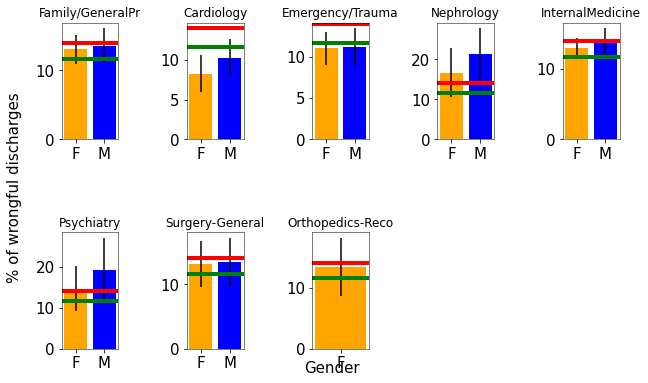

In [134]:
colors = {"Female": "orange", "Male": "blue"}
xlabels = {"Female": "F", "Male": "M"}
n_cols = 5
if len(axs)/n_cols == len(axs)//n_cols: n_rows = len(axs)//n_cols
else : n_rows = len(axs)//n_cols+1

fig, ax = plot_figure(fig_width=n_cols*2, fig_height=2*n_rows+2)

new_axs = []
for plot_num, ax_saved in enumerate(axs):
    ax = plt.subplot(len(axs)//n_cols+1, n_cols, plot_num+1)
   # ... do some plotting

    ax.bar([xlabels[g] for g in ax_saved[0]], ax_saved[1], yerr = ax_saved[2], color = [colors[l] for l in ax_saved[0]])

    plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
    plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
    plt.title(groups_to_plot[plot_num][0:16], fontsize=12)
    new_axs.append(ax)

#ax.get_shared_x_axes().join(new_axs[n_rows-1], new_axs[n_rows*2-1], new_axs[n_rows*3-1], new_axs[n_rows*4-1])

plt.subplots_adjust(hspace=0.8, wspace = 1.2)
fig.text(0.5, 0.08, 'Gender', ha='center', va='center')
fig.text(0.06, 0.5, '% of wrongful discharges', ha='center', va='center', rotation='vertical')
fig.savefig(f'specialty_gender_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [ ]:
column_name = "race"

axs = []
groups_to_plot = []
for sub_group in groups:
    all_data = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Gender", min_size=0, min_size_wrong=5, return_figure=False)
    if all_data:
        x_values, y_values, error = all_data
        axs.append([x_values, y_values, error])
        groups_to_plot.append(sub_group)

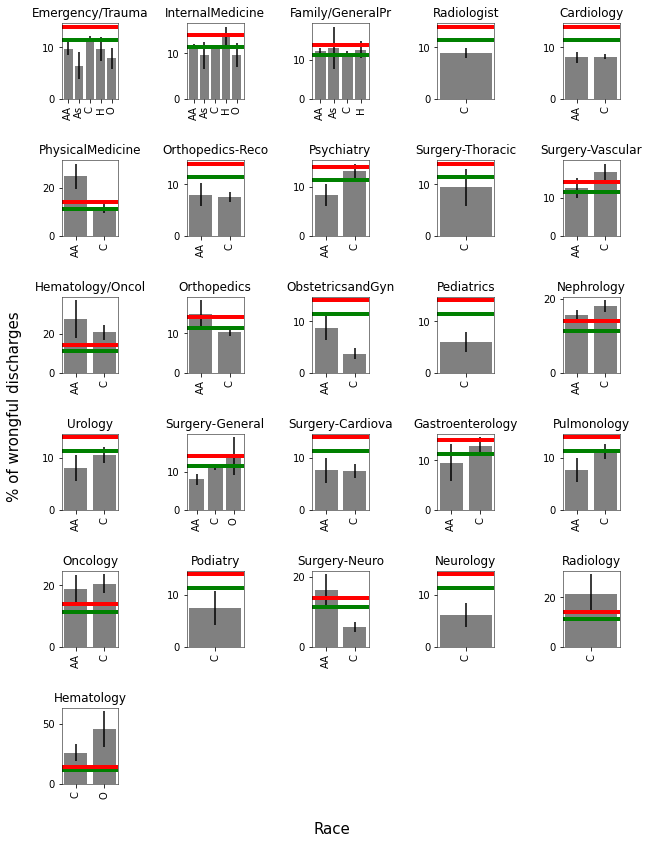

In [ ]:
xlabels = {"African American": "AA", "Asian": "As", "Caucasian": "C", "Hispanic": "H", "Other": "O"}
n_cols = 5
if len(axs)/n_cols == len(axs)//n_cols: n_rows = len(axs)//n_cols
else : n_rows = len(axs)//n_cols+1

fig, ax = plot_figure(fig_width=n_cols*2, fig_height=2*n_rows+2)

new_axs = []
for plot_num, ax_saved in enumerate(axs):
    ax = plt.subplot(len(axs)//n_cols+1, n_cols, plot_num+1)
   # ... do some plotting

    ax.bar([xlabels[g] for g in ax_saved[0]], ax_saved[1], yerr = ax_saved[2], color = bars_color)

    plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
    plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
    plt.title(groups_to_plot[plot_num][0:16], fontsize=12)
    plt.xticks(fontsize= 10, rotation=90) 
    plt.yticks(fontsize= 10) 

    new_axs.append(ax)

#ax.get_shared_x_axes().join(new_axs[n_rows-1], new_axs[n_rows*2-1], new_axs[n_rows*3-1], new_axs[n_rows*4-1])

plt.subplots_adjust(hspace=0.8, wspace = 1.2)
fig.text(0.5, 0.08, 'Race', ha='center', va='center')
fig.text(0.06, 0.5, '% of wrongful discharges', ha='center', va='center', rotation='vertical')
fig.savefig(f'specialty_race_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [ ]:
column_name = "age"

axs = []
groups_to_plot = []
for sub_group in groups:
    all_data = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Gender", min_size=0, min_size_wrong=5, return_figure=False)
    if all_data:
        x_values, y_values, error = all_data
        axs.append([x_values, y_values, error])
        groups_to_plot.append(sub_group)


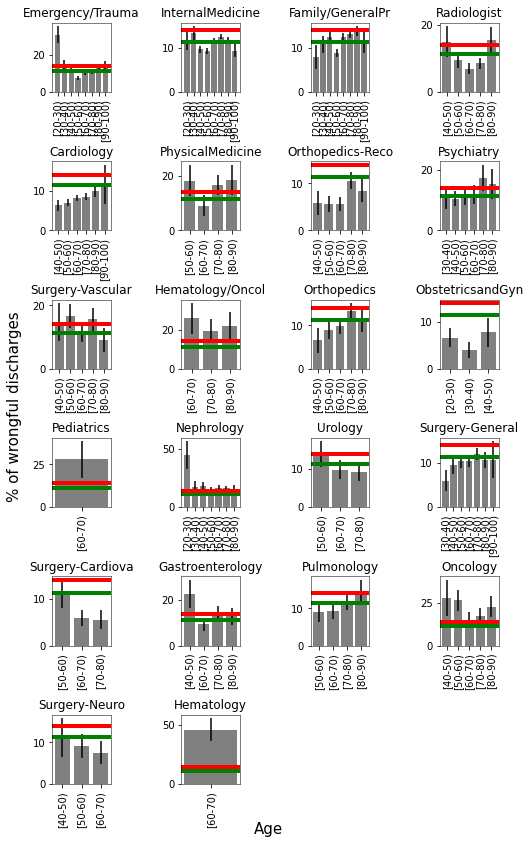

In [ ]:
#xlabels = {"African American": "AA", "Asian": "As", "Caucasian": "C", "Hispanic": "H", "Other": "O"}
n_cols = 4
if len(axs)/n_cols == len(axs)//n_cols: n_rows = len(axs)//n_cols
else : n_rows = len(axs)//n_cols+1

fig, ax = plot_figure(fig_width=n_cols*2, fig_height=2*n_rows+2)

new_axs = []
for plot_num, ax_saved in enumerate(axs):
    ax = plt.subplot(len(axs)//n_cols+1, n_cols, plot_num+1)
   # ... do some plotting

    ax.bar(ax_saved[0], ax_saved[1], yerr = ax_saved[2], color = bars_color)

    plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
    plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
    plt.title(groups_to_plot[plot_num][0:16], fontsize=12)
    plt.xticks(fontsize= 10, rotation=90) 
    plt.yticks(fontsize= 10) 

    new_axs.append(ax)

#ax.get_shared_x_axes().join(new_axs[n_rows-1], new_axs[n_rows*2-1], new_axs[n_rows*3-1], new_axs[n_rows*4-1])

plt.subplots_adjust(hspace=1, wspace = 1.2)
fig.text(0.5, 0.08, 'Age', ha='center', va='center')
fig.text(0.06, 0.5, '% of wrongful discharges', ha='center', va='center', rotation='vertical')
fig.savefig(f'specialty_age_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [ ]:
column_name = "isInsured"

axs = []
groups_to_plot = []
for sub_group in groups:
    all_data = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Gender", min_size=0, min_size_wrong=5, return_figure=False)
    if all_data:
        x_values, y_values, error = all_data
        axs.append([x_values, y_values, error])
        groups_to_plot.append(sub_group)


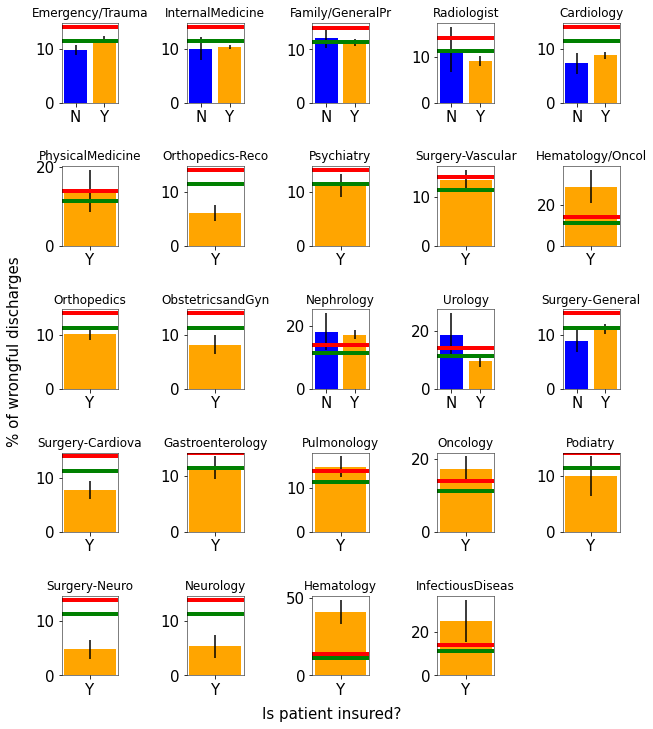

In [ ]:
colors = {"Yes": "orange", "No": "blue"}
xlabels = {"Yes": "Y", "No": "N"}

n_cols = 5
if len(axs)/n_cols == len(axs)//n_cols: n_rows = len(axs)//n_cols
else : n_rows = len(axs)//n_cols+1

fig, ax = plot_figure(fig_width=n_cols*2, fig_height=2*n_rows+2)

new_axs = []
for plot_num, ax_saved in enumerate(axs):
    ax = plt.subplot(len(axs)//n_cols+1, n_cols, plot_num+1)
   # ... do some plotting

    ax.bar([xlabels[g] for g in ax_saved[0]], ax_saved[1], yerr = ax_saved[2], color = [colors[l] for l in ax_saved[0]])

    plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
    plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
    plt.title(groups_to_plot[plot_num][0:16], fontsize=12)
    new_axs.append(ax)

#ax.get_shared_x_axes().join(new_axs[n_rows-1], new_axs[n_rows*2-1], new_axs[n_rows*3-1], new_axs[n_rows*4-1])

plt.subplots_adjust(hspace=0.8, wspace = 1.2)
fig.text(0.5, 0.08, 'Is patient insured?', ha='center', va='center')
fig.text(0.06, 0.5, '% of wrongful discharges', ha='center', va='center', rotation='vertical')
fig.savefig(f'specialty_insurance_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')

